In [1]:
import json
import requests 
import urllib
from urllib.request import urlopen
import pandas as pd
from rdkit import Chem
from urllib.parse import quote

In [2]:

def fetch_nonpolymer_entities_by_gene(gene_name, n=1000):
    """
    Fetches nonpolymer entities from the RCSB REST API based on a gene name.
    Returns up to 'n' results, defaulting to 100.
    """
    base_url = 'https://search.rcsb.org/rcsbsearch/v2/query'
    query = {
        "query": {
            "type": "terminal",
            # "service": "text",
            # "parameters": {
            #     "attribute": "rcsb_entity_source_organism.rcsb_gene_name.value",
            #     "operator": "exact_match",
            #     "value": gene_name
            # }
            "service": "full_text",
            "parameters": {
            "value": gene_name
            }
        },
  "request_options": {
    "paginate": {
      "start": 0,
      "rows": n
    }
  },
        "return_type": "entry"
    }

    try:
        # Convert the query to JSON and include it as a URL parameter
        query_string = json.dumps(query)
        url = f"{base_url}?json={query_string}"
        response = requests.get(url)
        response.raise_for_status()
        output = response.json()
        return output
    except requests.RequestException as e:
        print(f"Error fetching nonpolymer entities for gene {gene_name}: {e}")
        return None

def fetch_component_identifiers(nonpolymer_ids):
    """
    Retrieves detailed component information for multiple nonpolymer entities
    using the RCSB GraphQL API with the specified query format.
    """
    base_url = 'https://data.rcsb.org/graphql?query='

    # Construct the query for multiple entry IDs
    entry_ids = ', '.join(f'"{entry}"' for entry in nonpolymer_ids)
    graphql_query = f"""
    {{
      entries(entry_ids: [{entry_ids}]) {{
        nonpolymer_entities {{
          rcsb_nonpolymer_entity_container_identifiers {{
            entry_id
          }}
          nonpolymer_comp {{
            chem_comp {{
              id
              # type
              # formula_weight
              # formula
            }}
            rcsb_chem_comp_descriptor {{
            #   InChI
            #   InChIKey
            SMILES_stereo
            }}
            # pdbx_chem_comp_descriptor {{
            #   descriptor
            #   type
            #   program
            # }}
          }}
        }}
      }}
    }}
    """
    
    # Encode the query as a URL parameter
    encoded_query = quote(graphql_query)
    full_url = base_url + encoded_query
    
    try:
        # print("Full GraphQL Query URL:", full_url)  # Debug: Log the query URL
        response = requests.get(full_url)
        response.raise_for_status()
        output = response.json()
        # print("GraphQL Response:", json.dumps(output, indent=2))  # Debug: Log the formatted response
        return output
    except requests.RequestException as e:
        print(f"Error fetching component identifiers: {e}")
        return None


def parse_component_identifiers(nonpolymer_ids, excluded_chem_comps=None):
    """
    Uses the fetch_component_identifiers function to retrieve chem_comp IDs and SMILES data.
    Filters out specified chem_comp IDs.

    Parameters:
        nonpolymer_ids (list): List of nonpolymer entry IDs to query.
        excluded_chem_comps (list): List of chem_comp IDs to exclude.

    Returns:
        pd.DataFrame: DataFrame with chem_comp IDs and SMILES.
        list: List of entry IDs with null nonpolymer_entities.
    """
    if excluded_chem_comps is None:
        excluded_chem_comps = ["CA","SO4","MG","EDO","CL","NA","ZN","GOL"]

    # Fetch data using the provided fetch_component_identifiers function
    output = fetch_component_identifiers(nonpolymer_ids)
    if not output or 'data' not in output or 'entries' not in output['data']:
        print("No valid data found in the response.")
        return pd.DataFrame(columns=['entry_id', 'chem_comp', 'SMILES'])

    excluded_ids = []
    chem_comp_data = []

    # Process each entry
    for entry in output['data']['entries']:
        if entry.get("nonpolymer_entities") is None:
            excluded_ids.append(entry.get('entry_id', None))
            continue

        # Extract details from nonpolymer_entities
        for entity in entry["nonpolymer_entities"]:
            entry_id = entity.get("rcsb_nonpolymer_entity_container_identifiers", {}).get("entry_id")
            chem_comp = entity.get("nonpolymer_comp", {}).get("chem_comp", {}).get("id")
            smiles = entity.get("nonpolymer_comp", {}).get("rcsb_chem_comp_descriptor", {}).get("SMILES_stereo")

            # Skip excluded chem_comp IDs
            if chem_comp in excluded_chem_comps:
                continue

            if entry_id and chem_comp and smiles:
                chem_comp_data.append({
                    "entry_id": entry_id,
                    "chem_comp": chem_comp,
                    "SMILES": smiles
                })

    # Convert the data into a DataFrame
    df = pd.DataFrame(chem_comp_data)

    return df


def get_nonpolymer_pdb_ids(gene_name,total_count):
    """
    Retrieves PDB IDs for nonpolymer entities associated with a given gene name.
    If more than 1000 entries exist, retrieves all of them.
    """
    # Fetch initial results
    output = fetch_nonpolymer_entities_by_gene(gene_name=gene_name,n=total_count)
    
    # if not output or 'total_count' not in output:
    #     return []
    
    # # If total count exceeds the default fetch limit, fetch all entries
    # total_count = output['total_count']
    # if total_count > 1000:
    output = fetch_nonpolymer_entities_by_gene(gene_name=gene_name)
    
    if not output or 'result_set' not in output:
        return []
    
    # Parse and return PDB identifiers
    return [entry['identifier'] for entry in output['result_set']]




In [3]:
nonpolymer_ids = get_nonpolymer_pdb_ids('FGFR1',1000)
chemical_components_df = parse_component_identifiers(nonpolymer_ids)


In [4]:
from rdkit.Chem import PandasTools
PandasTools.AddMoleculeColumnToFrame(chemical_components_df,'SMILES','Molecule')



[14:24:30] Explicit valence for atom # 4 O, 6, is greater than permitted


,entry_id,chem_comp,SMILES,Molecule
0,4V05,66T,C[C@@H]1CN(C[C@@H](N1)C)c2ccc(cc2)C(=O)Nc3cc(n...,
1,4V04,0LI,Cc1ccc(cc1C#Cc2cnc3n2nccc3)C(=O)Nc4ccc(c(c4)C(...,
2,6MZQ,TZ0,COc1cc(cc(c1)OC)C#Cc2c3c(ncnc3n(n2)[C@H]4CCN(C...,
3,6MZW,TZ0,COc1cc(cc(c1)OC)C#Cc2c3c(ncnc3n(n2)[C@H]4CCN(C...,
4,4UXQ,0LI,Cc1ccc(cc1C#Cc2cnc3n2nccc3)C(=O)Nc4ccc(c(c4)C(...,
...,...,...,...,...
65,3KRJ,ACT,CC(=O)[O-],
66,3KRJ,KRJ,c1cc(c(cc1C2CCNCC2)C3=CCCCC3)NC(=O)c4[nH]cc(n4...,
67,3KRL,KRL,CN1CCN(CC1)c2ccc(c(c2)N3CCCCC3)NC(=O)c4ccc(o4)C#N,
68,7TNH,I9W,Cc1c(ccc(n1)NC(=O)NC(=O)C(C)(C)C)Oc2ccnc(c2)c3...,

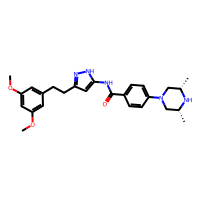
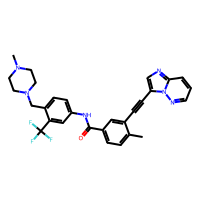
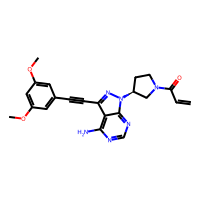
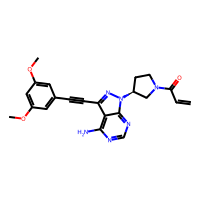
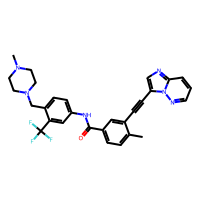
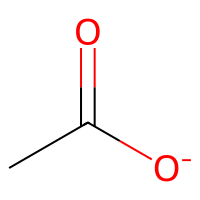
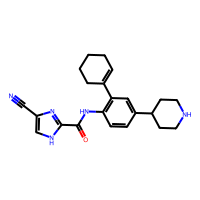
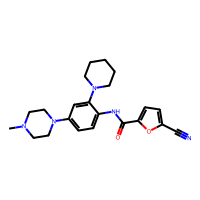
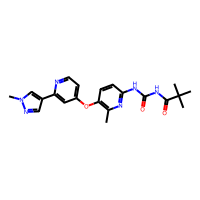
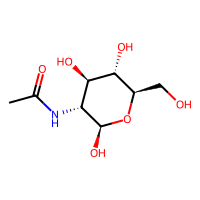

In [5]:
chemical_components_df